In [1]:
%matplotlib inline  
import timeit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from PIL import Image
import cv2
import os
from tensorflow.keras import layers, models

faces_path = 'turtle_data\\faces3\\Faces3'
no_faces_path = 'turtle_data\\noFaces3\\noFaces3'

In [2]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img.shape[0]==198 and img.shape[1]==198:
            images.append(img)
    return images

images_with_face = np.array(load_images_from_folder(faces_path))
images_without_face = np.array(load_images_from_folder(no_faces_path))

In [3]:
#checking shapes
print('faces data shape: ', images_with_face.shape)
print('no faces data shape: ', images_without_face.shape)

# merge the faces/nofaces arrays
images = np.concatenate((images_with_face, images_without_face))
print('\nTotal dataset shape: ', images.shape)

L = 1999
#defining labels
labels_face = np.ones(L)
labels_noface = np.zeros(L)
labels = np.concatenate((labels_face, labels_noface))
#checking labels
unique, counts = np.unique(labels, return_counts=True)
print('\n\nlables \nuniques: ', unique, '\ncounts:', counts)

faces data shape:  (1999, 198, 198, 3)
no faces data shape:  (1999, 198, 198, 3)

Total dataset shape:  (3998, 198, 198, 3)


lables 
uniques:  [0. 1.] 
counts: [1999 1999]


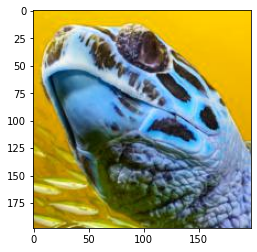

label:  1.0  --> FACE


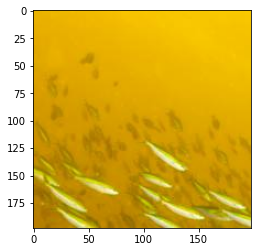

label:  0.0  --> NO FACE


In [4]:
def show_image(x, y, index):
    categ=''
    plt.imshow(x[index])
    plt.show()
    if y[index]==0 : categ='NO FACE'
    elif y[index]==1 : categ='FACE'
    else: 'ERROR'   
    print('label: ', y[index], " -->", categ)
    
show_image(images, labels, 0)
show_image(images, labels, 1999)

In [5]:
images[0].shape

(198, 198, 3)

### CNN Implementation

In [6]:
seed = 2056112
np.random.seed(seed)

# X,y
X = np.copy(images)
y = np.copy(labels)

permutation = np.random.permutation(len(y)) # permutation is a list of shuffled indexes

X = X[permutation]
y = y[permutation]

#training-test split
perc_training = 0.8
m_training = int(len(y)*0.8)
m_test = len(y) - int(len(y)*0.8)

X_train, X_test = X[:m_training], X[m_training:m_training+m_test]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test]

Some stats about training and test datasets

In [7]:
labels_tr, freqs_tr = np.unique(y_train, return_counts=True)
print("Total Training data:", m_training)
print("Labels in training dataset: ", labels_tr)
print("Frequencies in training dataset: ", freqs_tr)

labels_tst, freqs_tst = np.unique(y_test, return_counts=True)
print("Total Test data:", m_test)
print("Labels in test set: ", labels_tst)
print("Frequencies in test set: ", freqs_tst)

Total Training data: 3198
Labels in training dataset:  [0. 1.]
Frequencies in training dataset:  [1578 1620]
Total Test data: 800
Labels in test set:  [0. 1.]
Frequencies in test set:  [421 379]


## CNN

In [16]:
def build_cnn():

    #filters: how many features/patterns we are going to recognize in the images
    #kernel: shape of the matrix used for each filter's convolution
    #pooling: shape of the matrix used to generalise the feature map created by the convolution (the smaller the shape the longer the computation time)
    
    cnn = models.Sequential([

        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        #dense
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(2, activation='softmax')
        
    ])
    
    # compile
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    #summary
    print(cnn.summary())
    return cnn

In [17]:
cnn = build_cnn()

start = timeit.default_timer()

fit = cnn.fit(X_train, y_train, epochs=30)

time_compiling = timeit.default_timer()-start

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 196, 196, 30)      840       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 19, 19, 30)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 17, 17, 30)        8130      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 30)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 30)                0         
                                                                 
 dense_2 (Dense)             (None, 50)               

In [18]:
print("time needed to compile the training set: ", time_compiling, " s")

time needed to compile the training set:  794.772502  s


In [19]:
cnn.evaluate(X_test, y_test)

25/25 [==============================] - 3s 102ms/step - loss: 0.4021 - accuracy: 0.8900


[0.4021070897579193, 0.8899999856948853]

let see the CNN at work in a prediction

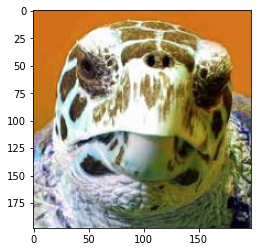

label:  1.0  --> FACE


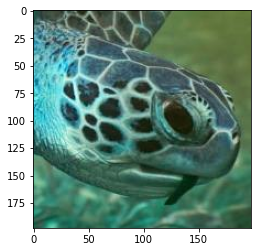

label:  1.0  --> FACE


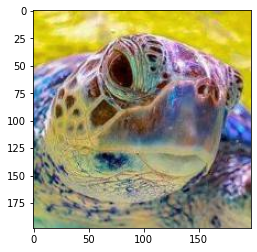

label:  1.0  --> FACE


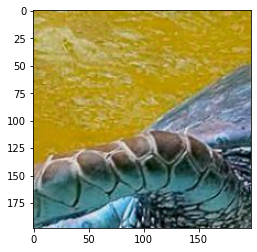

label:  0.0  --> NO FACE


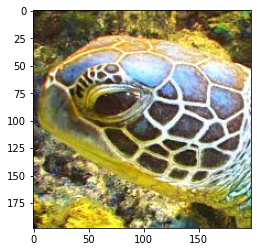

label:  1.0  --> FACE


In [20]:
some_indexes = [0,10,23,111,201]
for i in some_indexes:
    show_image(X_test, y_test, i)

### CNN Accuracy plot

In [23]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

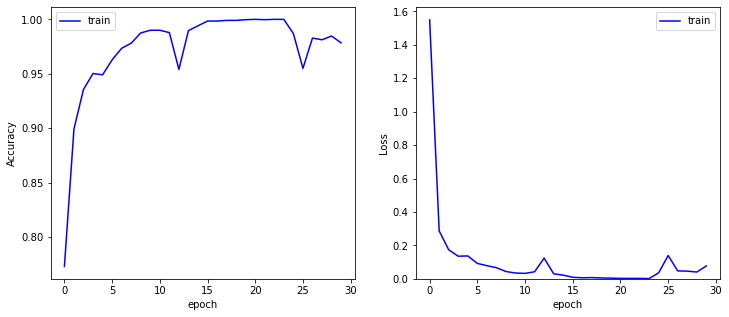

In [24]:
Show_history(fit)